In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


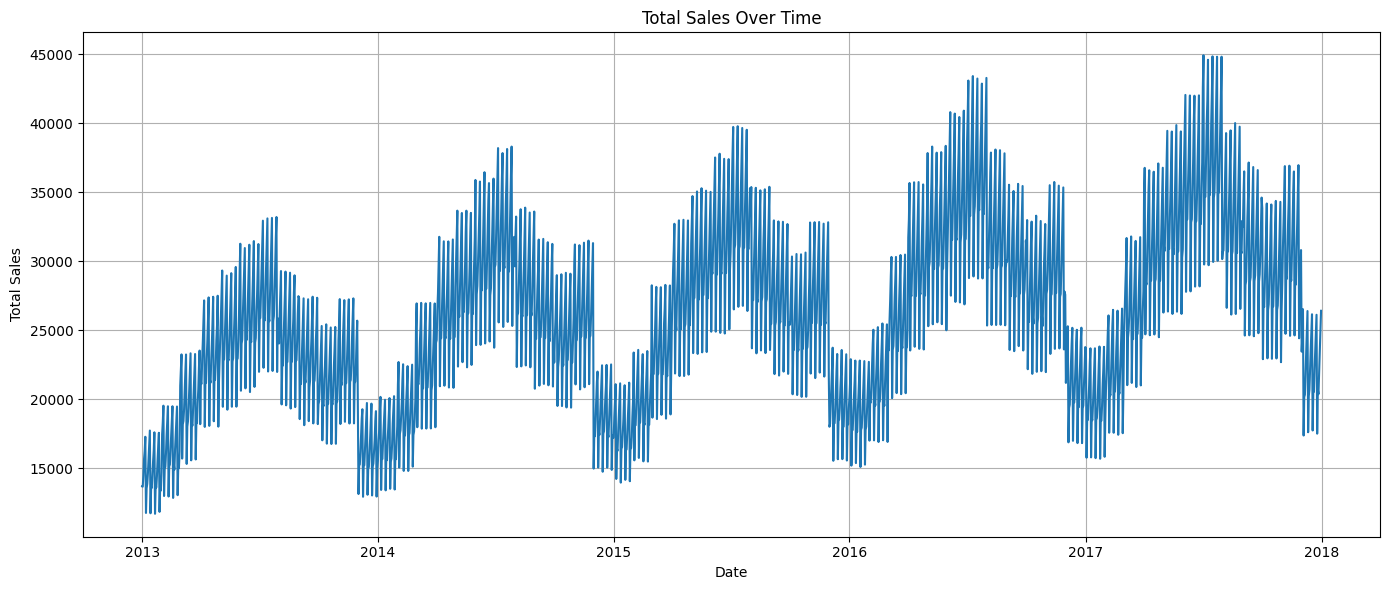

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sales_by_date = train.groupby('date')['sales'].sum()

plt.figure(figsize=(14, 6))
sns.lineplot(x=sales_by_date.index, y=sales_by_date.values)
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

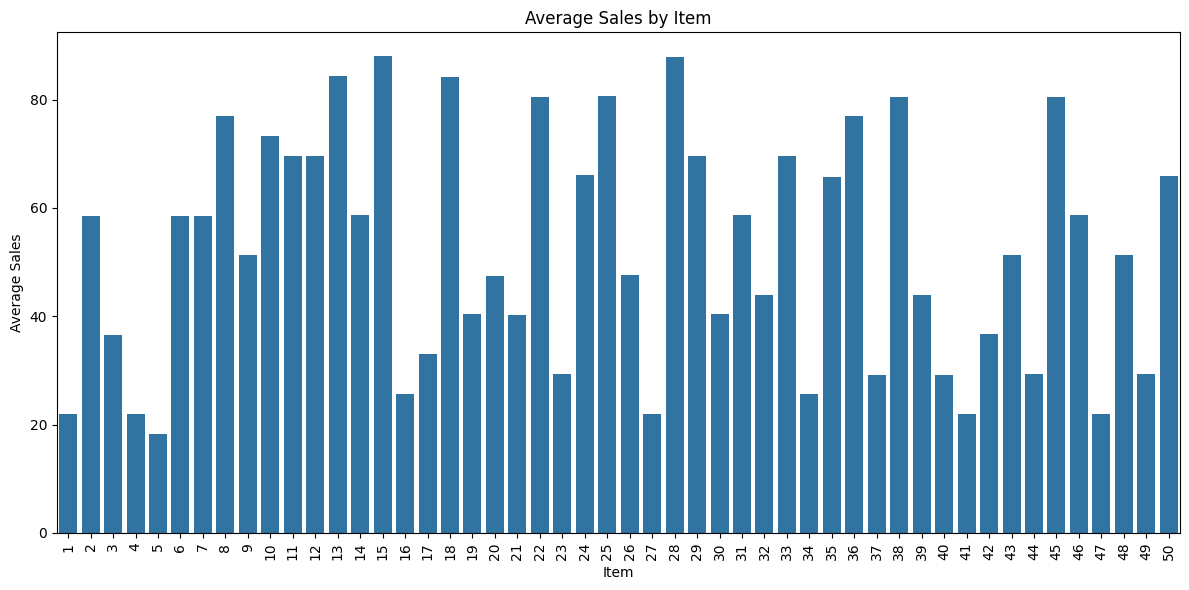

In [3]:
avg_sales_by_item = train.groupby('item')['sales'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_sales_by_item.index, y=avg_sales_by_item.values)
plt.title('Average Sales by Item')
plt.xlabel('Item')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

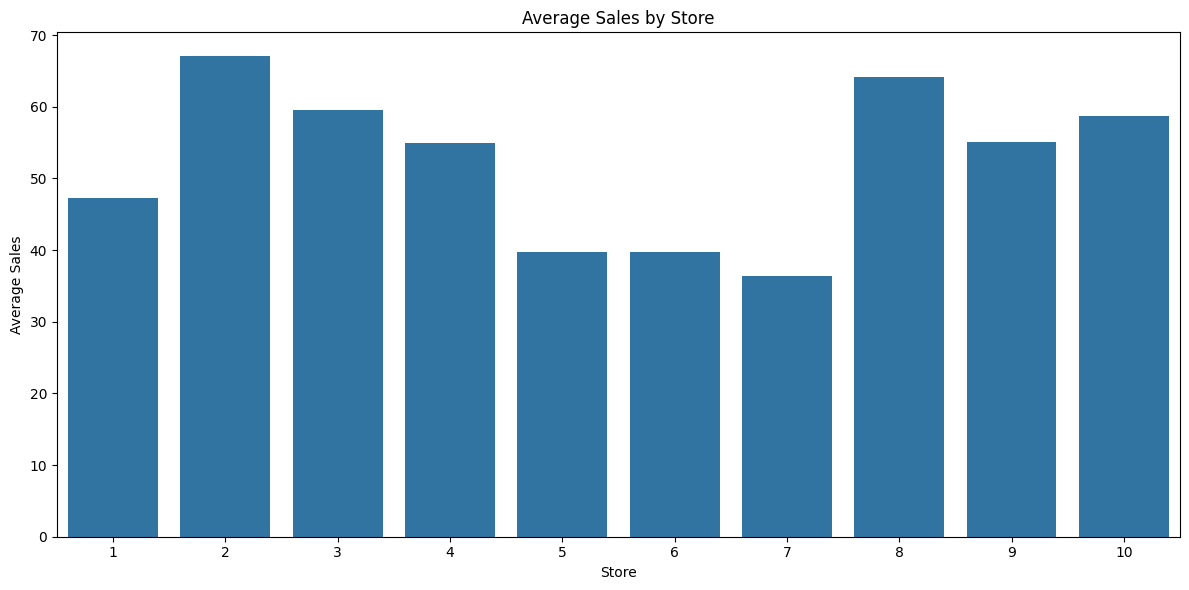

In [4]:
avg_sales_by_store = train.groupby('store')['sales'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_sales_by_store.index, y=avg_sales_by_store.values)
plt.title('Average Sales by Store')
plt.xlabel('Store')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

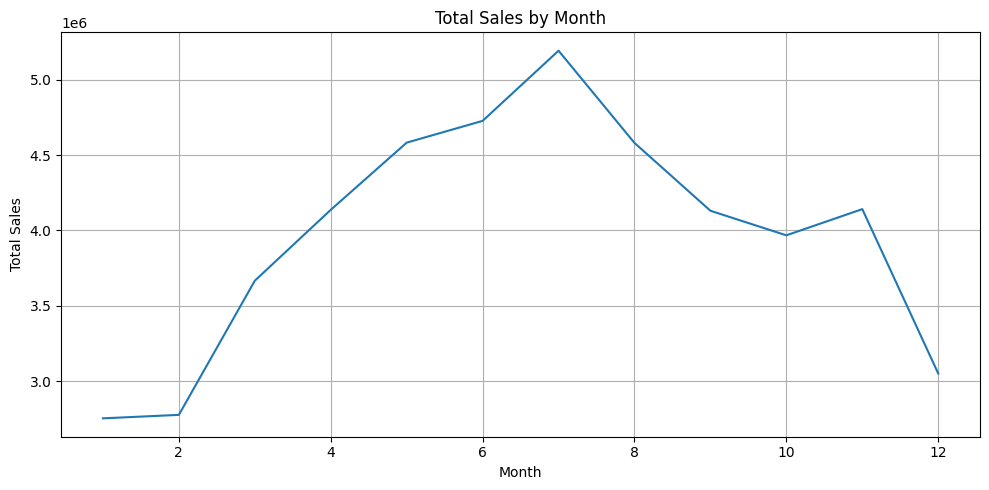

In [5]:
train['month'] = train['date'].dt.month

monthly_sales = train.groupby('month')['sales'].sum()

plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

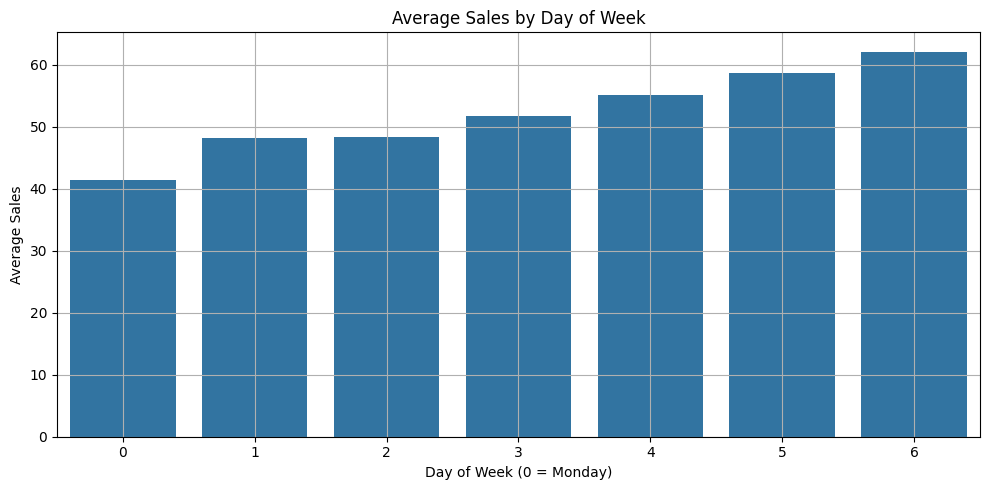

In [6]:
# Add day of week (0=Monday, 6=Sunday)
train['day_of_week'] = train['date'].dt.dayofweek

dow_sales = train.groupby('day_of_week')['sales'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=dow_sales.index, y=dow_sales.values)
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week (0 = Monday)')
plt.ylabel('Average Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

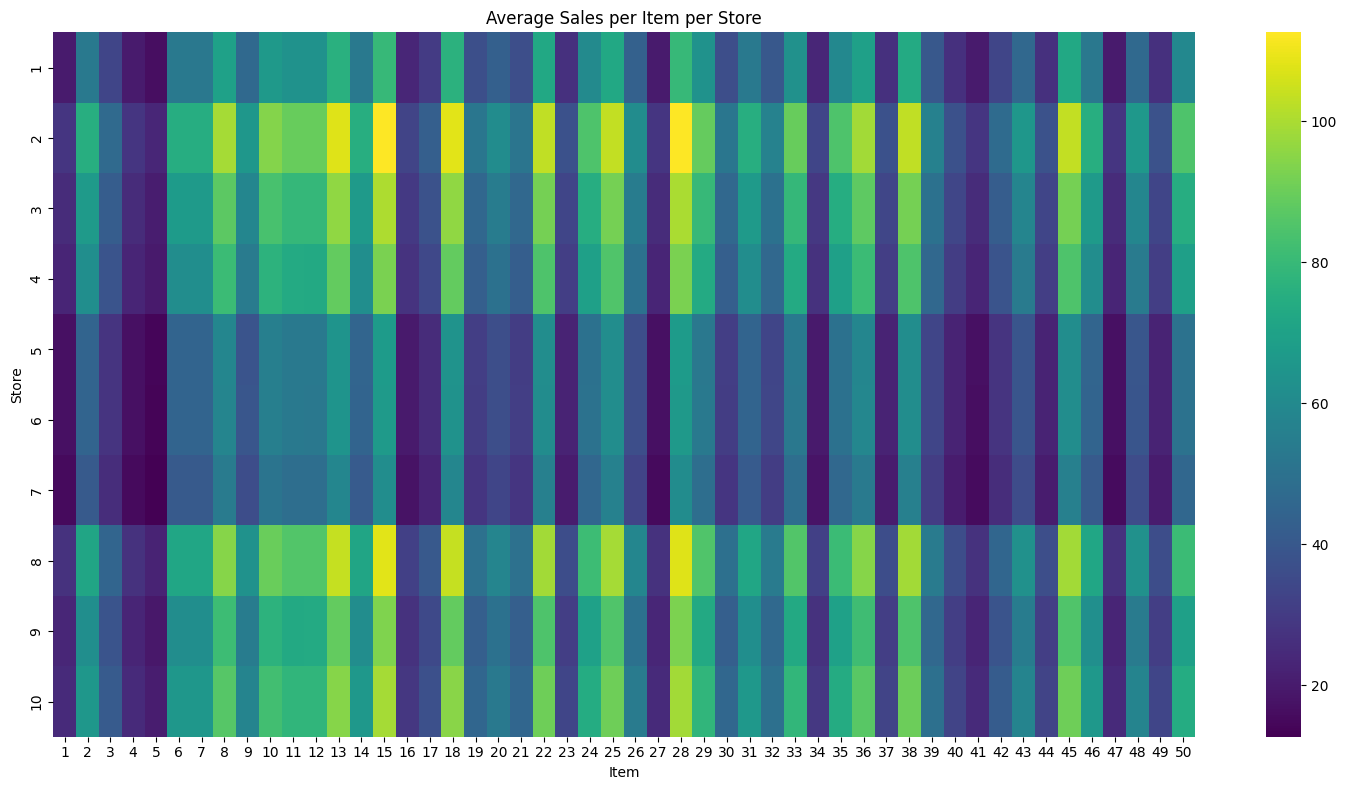

In [7]:
# Create pivot table
pivot_table = train.pivot_table(values='sales', index='store', columns='item', aggfunc='mean')

plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, cmap='viridis')
plt.title('Average Sales per Item per Store')
plt.xlabel('Item')
plt.ylabel('Store')
plt.tight_layout()
plt.show()

In [8]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek
train['is_weekend'] = train['day_of_week'].isin([5, 6]).astype(int)

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.dayofweek
test['is_weekend'] = test['day_of_week'].isin([5, 6]).astype(int)

In [9]:
# Sort before creating lag features
train = train.sort_values(by=['store', 'item', 'date'])

# Group by store & item, then shift
train['sales_last_day'] = train.groupby(['store', 'item'])['sales'].shift(1)
train['sales_last_7_avg'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=7).mean().reset_index(drop=True)

In [10]:
# Rolling median and standard deviation (7-day window)
train['sales_last_7_median'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=7).median().reset_index(drop=True)
train['sales_last_7_std'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=7).std().reset_index(drop=True)

In [11]:
# Mark weekends as simulated promotions
train['promo'] = train['is_weekend']
test['promo'] = test['is_weekend']

In [12]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=train['date'].min(), end=train['date'].max())

train['is_holiday'] = train['date'].isin(holidays).astype(int)
test['is_holiday'] = test['date'].isin(holidays).astype(int)

In [13]:
train_model = train.dropna().copy()

In [14]:
# Features to use (you can add/remove more later)
features = [
    'store', 'item', 'year', 'month', 'day', 'day_of_week', 'is_weekend',
    'sales_last_day', 'sales_last_7_avg', 'sales_last_7_median', 'sales_last_7_std',
    'promo', 'is_holiday'
]

X = train_model[features]
y = train_model['sales']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"Linear Regression RMSE: {rmse:.2f}")
print(f"Linear Regression MAE: {mae:.2f}")

Linear Regression RMSE: 12.48
Linear Regression MAE: 9.56


In [18]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_val)

rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
mae_rf = mean_absolute_error(y_val, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest MAE: {mae_rf:.2f}")

Random Forest RMSE: 10.04
Random Forest MAE: 7.70


In [19]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)

rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost MAE: {mae_xgb:.2f}")

XGBoost RMSE: 8.57
XGBoost MAE: 6.58


In [20]:
# Add lag features to test set
test = test.sort_values(by=['store', 'item', 'date'])

# Merge train + test for continuous lag feature creation
combined = pd.concat([train[['store', 'item', 'date', 'sales']], test[['store', 'item', 'date']]], sort=False)
combined = combined.sort_values(by=['store', 'item', 'date'])

# Create lag features
combined['sales_last_day'] = combined.groupby(['store', 'item'])['sales'].shift(1)
combined['sales_last_7_avg'] = combined.groupby(['store', 'item'])['sales'].shift(1).rolling(7).mean().reset_index(drop=True)
combined['sales_last_7_median'] = combined.groupby(['store', 'item'])['sales'].shift(1).rolling(7).median().reset_index(drop=True)
combined['sales_last_7_std'] = combined.groupby(['store', 'item'])['sales'].shift(1).rolling(7).std().reset_index(drop=True)

test = combined[combined['sales'].isna()].copy().reset_index(drop=True)

original_test = pd.read_csv("test.csv")[['id']]
test['id'] = original_test['id'].values


In [21]:
# Add missing date-based features to test
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.dayofweek
test['is_weekend'] = test['day_of_week'].isin([5, 6]).astype(int)
test['promo'] = test['is_weekend']
test['is_holiday'] = test['date'].isin(train['date'][train['is_holiday'] == 1]).astype(int)

In [22]:
# Predict on test set using XGBoost
X_test = test[features]
test['sales'] = xgb.predict(X_test)
test['sales'] = test['sales'].round().astype(int)

# Final submission with date for Tableau
submission_final = test[['id', 'store', 'item', 'date', 'sales']]
submission_final.to_csv("submission.csv", index=False)

print("✅ submission.csv saved with date, ready for Tableau.")

✅ submission.csv saved with date, ready for Tableau.
